## RECEPTI, *Projektna naloga pri predemtu Programiranje 1*
#### Marija Jezeršek

### Uvod:

V tej projektni nalogi analiziram recepte s strani "Kulinarika.net". S strani sem zajela podatke 12766 receptov iz kategorij juhe, solate, priloge, mesne jedi, zelenjavne jedi in sladice. Vsak recept ima podatke o imenu recepta in avtorja, času priprave, povprečni oceni, kategoriji, sestavinah in postopku priprave. Poleg tega ima vsak recept tudi svoj indeks, ki povezuje osnovne podatke recepta s podatki o sestavinah in postopku, ki so shranjeni v različnih CSV-datotekah.

Delovne hipoteze, ki sem si jih zastavila in so obravnavane v projektu, so:
- Kakšna je povezava med zahtevnostjo priprave in dolžino navodil, časom priprave ter številom različnih sestavin?
- Jedi s katereimi sestavinami imajo najboljše ocene?
- Z uporabo naivnega Bayesovega klasifikatorja poskusim iz sestavin napovedati kategorijo jedi.

In [297]:
# naložimo paket
import pandas as pd
import re
from tqdm import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.set_option('display.max_rows', 10)

Ker nam tudi Kulinarika poda svojo oceno zahtevnosti (sklepam, da gre za (subjektivno) oceno avtorja recepta), bom s shranjenih html strani najprej pridobila še podatke o tem, da jih bom kasneje lahko primerjala s svojo oceno.

In [242]:
recepti = pd.read_csv('podatki_z_indeksi.csv')

recepti['predvidena_tezavnost'] = 0
predvidena_tezavnost = recepti['predvidena_tezavnost']

for vrstica in tqdm(recepti.iloc, total=len(recepti)):
    pot = f"html_strani/{vrstica['indeks']}.html"

    with open(pot, 'r', encoding='utf-8') as d:
        vsebina = d.read()
    vzorec_zahtevnost = re.compile(r"""<img src='/grafika6/ikona-utez.png'""", re.DOTALL)
    z = re.findall(vzorec_zahtevnost, vsebina)

    predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)


recepti.to_csv('podatki_z_indeksi.csv')

  0%|          | 0/12766 [00:00<?, ?it/s]C:\Users\Marija\AppData\Local\Temp\ipykernel_12740\3744588564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)
100%|██████████| 12766/12766 [00:38<00:00, 330.35it/s]


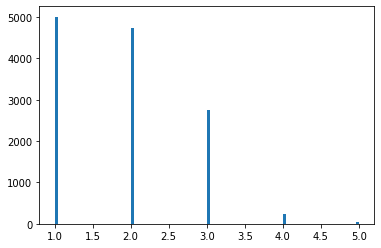

In [298]:
recepti = pd.read_csv('podatki_z_indeksi.csv')

_ = plt.hist(recepti["predvidena_tezavnost"], bins=100)

Kulinarika torej večino receptov oceni kot enostavne ... Kaj pa mi?

### Indeks zahtevnosti priprave:

Po moji oceni je zahtevnost priprave odvisna od časa priprave $ t $, dolžine opisa postopka priprave $ l $ in številom različnih sestavin $ n $, ki jih potrebuješ za pripravo jedi. Na podlagi teh parametrov bom za vsak recept izračunala indeks zahtevnosti priprave recepta $ z $ po formuli:
$$ z =  t l \log n  $$

In [299]:
def cas_v_minutah(niz):
    """ Pretvori čas priprave v celo število minut, potrebnih za priprvo. """
    if "ur" in niz and "min" in niz:
        return str(int(re.findall(r"\d+", niz)[0]) * 60 + int(re.findall(r"\d+", niz)[1]))
    elif niz[-3:] == 'min':
        return str(niz.split(' ')[0])
    elif niz[-3:] in {'ura', ' ur', 'ure', "uri"}:
        return str(int(re.findall(r"\d+", niz)[0]) * 60)
    else:
        return None

def povp(df):
    return (df - df.mean()) / df.std()

def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [300]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')
postopki = pd.read_csv('postopki.csv')


recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()
t = pd.to_numeric(recepti["čas_priprave_min"])[maska]


t_norm = povp(t)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l_ = l

l_norm = povp(l_)

n = sestavine.groupby("indeks").size()[maska]
n_ = np.log(n)

n_norm = povp(n_)

zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t_norm * l_norm * n_norm)
recepti["zahtevnost"] = povp(zahtevnost)


Zdaj smo dobili porazdelitev receptov glede na njihovo zahtevnost, izračunano po naši formuli in standardno porazdeljene. Sedaj bomo odstranili 20 največjih in najmanjših, jim dali oceno 5 oz. 0, ostale pa normirali od 0 do 5.

lower: -1.8636943557439394, upper: 3.0709304681578353
0 5


C:\Users\Marija\AppData\Local\Temp\ipykernel_9848\775650510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recepti["zahtevnost"][maska_na] = zahtevnost_brez_na


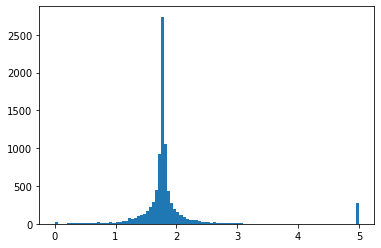

In [301]:
maska_na = ~recepti['zahtevnost'].isna()
zahtevnost_brez_na = recepti['zahtevnost'][maska_na]
sez = zahtevnost_brez_na.copy().to_numpy()
sez.sort()
lower, upper = sez[20], sez[-100]

print(f"lower: {lower}, upper: {upper}")

maska = (zahtevnost_brez_na < upper) & (zahtevnost_brez_na > lower)

zahtevnost_brez_na[maska] = 5 * minmax(zahtevnost_brez_na[maska])
zahtevnost_brez_na[zahtevnost_brez_na >= upper] = 5
zahtevnost_brez_na[zahtevnost_brez_na <= lower] = 0
print(zahtevnost_brez_na.min(), zahtevnost_brez_na.max())

_ = plt.hist(zahtevnost_brez_na.to_numpy(), bins=100)



recepti["zahtevnost"][maska_na] = zahtevnost_brez_na

# a = recepti.groupby("zahtevnost").size()
# a.plot()

Dobili smo ocene zahtevnosti analiziranih receptov glede na izbrani kriterij.

Sedaj pa nas zanima še primerjava med našimi izračuni in ocenami, ki so jih predvideli avtorji receptov.
Izračunamo razmerje $z/t$, kjer je $z$ zahtevnost, izračunana po naših postopkih, $t$ pa predvidena težavnost, podana na strani. Odstopanje zahtevnosti podem izrazimo kot $1 - z/t$.

In [302]:
recepti["odstopanje_zahtevnosti"] = 1 - recepti["zahtevnost"] / recepti["predvidena_tezavnost"]

C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


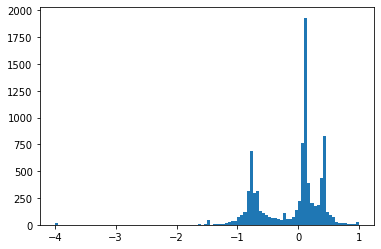

In [303]:
%matplotlib inline

_ = plt.hist(recepti["odstopanje_zahtevnosti"], bins=100)

Opazimo lahko, da so na ta način dobljena odstopanja večinoma med vrednostima + 1 in - 1. Večina receptov na ta način dobi oceno malce pod 2.

Preverimo lahko še, kolikšna so odstopanja pri predvideno lažjih oz. težjih receptih.

<AxesSubplot: xlabel='zahtevnost', ylabel='predvidena_tezavnost'>

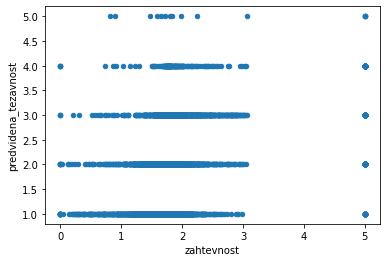

In [304]:
recepti.sort_values('zahtevnost').plot.scatter(x='zahtevnost', y='predvidena_tezavnost')

Oceno težavnosti poskusimo določiti še na drug način: postavimo kriterij, po katerem od 0 do 5 ocenimo težavnost časa priprave, števila sestavin in dolžine postopka. Nato izračunamo njihovo povprečje, kar postane skupna ocena zahtevnosti.

In [305]:
def casovni_kriterij(cas_v_minutah):
    cas_v_minutah = int(cas_v_minutah)
    if cas_v_minutah >= 69:
        return 5
    else:
        return (0.0971636 * (cas_v_minutah ** 0.944257)) - 0.383887

def sestavine_kriterij(st_sestavin):
    if st_sestavin >= 11:
        return 5
    else:
        return (st_sestavin - 3) / 2 

def postopek_kriterij(dolzina_postopka):
    if dolzina_postopka <= 10:
        return 0
    elif dolzina_postopka >= 435:
        return 5
    else:
        return (0.257975 * (dolzina_postopka ** 0.513715)) - 0.853943


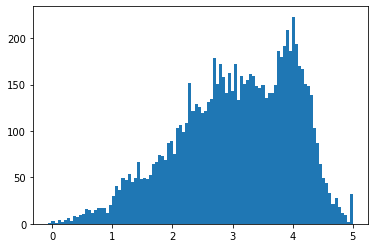

In [306]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')
postopki = pd.read_csv('postopki.csv')


recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()
t = recepti["čas_priprave_min"][maska].apply(casovni_kriterij)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l = l.apply(postopek_kriterij)

n = sestavine.groupby("indeks").size()[maska]
n = n.apply(sestavine_kriterij)



zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t + l + n) / 3
recepti["zahtevnost1"] = zahtevnost

_ = plt.hist(pd.to_numeric(recepti["zahtevnost1"]), bins=100)

C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


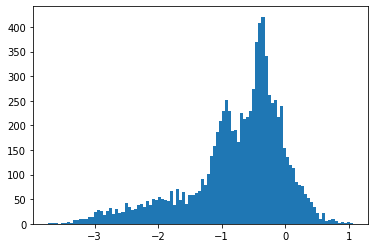

In [307]:
recepti["odstopanje_zahtevnosti1"] = 1 - recepti["zahtevnost1"] / recepti["predvidena_tezavnost"]

_ = plt.hist(recepti["odstopanje_zahtevnosti1"], bins=100)

Po tej oceni so recepti v povprečju zahtevnejši, pa tudi odstopanja s predvivenimi vrednostmi so večja.

### Napoved kategorije iz sestavin z uporabo naivnega Bayesovega klasifikatorja

Z uporabo naivnega Bayesovega klasifikatorja iz sestavin poskusimo določiti kategorijo jedi.

Hipoteza: za sladice in mesne jedi, katerih večinska sestavina je meso, bo napoved precej natančna, za ostale kategorije pa ne tako zelo.

In [308]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')

zdruzena = pd.merge(recepti, sestavine)
zdruzena.drop(["povezava", "avtor", "čas_priprave", "povprečna_ocena", "predvidena_tezavnost"], axis=1)

,Unnamed: 0,indeks,ime,kategorija,količina,sestavina
0,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,šarenke
1,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,čebule
2,0,0,Cmočki šarenke v žametni bučni juhi,juha,NaN,česen
3,0,0,Cmočki šarenke v žametni bučni juhi,juha,1 šopek,peteršilja
4,0,0,Cmočki šarenke v žametni bučni juhi,juha,400 g,krompirja
...,...,...,...,...,...,...
162301,12765,12765,Jagodni semifreddo,sladice,1,jajce
162302,12765,12765,Jagodni semifreddo,sladice,100 g,mlečne čokolade
162303,12765,12765,Jagodni semifreddo,sladice,400 g,jagod
162304,12765,12765,Jagodni semifreddo,sladice,500 ml,smetane za stepanje


Najprej izračunamo verjetnost, da se določena kategorija sploh pojavi.

In [309]:
verjetnosti_kategorij = recepti.groupby('kategorija').count()["ime"] / len(recepti)
verjetnosti_kategorij

kategorija
juha         0.049977
meso         0.139825
priloga      0.070265
sladice      0.624393
solata       0.043788
zelenjava    0.071753
Name: ime, dtype: float64

Sedaj bomo izračunali verjetnost, da se sestavina pojavi v posameznih kategorijah.

Najprej iz sestavin odstranimo morebitne povezave na reklame in opombe v oklepajih, ki jih dodajajo nekateri avtorji receptov:

In [310]:
def odstrani_html(x):
    return re.sub('<[^<]+?>', '', str(x))

def odstrani_opombe(x):
    return re.sub('\(.*?\)', '', str(x))

zdruzena["sestavina"] = zdruzena["sestavina"].apply(odstrani_html)
zdruzena["sestavina"] = zdruzena["sestavina"].apply(odstrani_opombe)

zdruzena.drop(["povezava", "avtor", "čas_priprave", "povprečna_ocena", "predvidena_tezavnost"], axis=1)

,Unnamed: 0,indeks,ime,kategorija,količina,sestavina
0,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,šarenke
1,0,0,Cmočki šarenke v žametni bučni juhi,juha,2 kosa,čebule
2,0,0,Cmočki šarenke v žametni bučni juhi,juha,NaN,česen
3,0,0,Cmočki šarenke v žametni bučni juhi,juha,1 šopek,peteršilja
4,0,0,Cmočki šarenke v žametni bučni juhi,juha,400 g,krompirja
...,...,...,...,...,...,...
162301,12765,12765,Jagodni semifreddo,sladice,1,jajce
162302,12765,12765,Jagodni semifreddo,sladice,100 g,mlečne čokolade
162303,12765,12765,Jagodni semifreddo,sladice,400 g,jagod
162304,12765,12765,Jagodni semifreddo,sladice,500 ml,smetane za stepanje


Sedaj iz sestavin izluščimo njihove korene.

In [311]:
def koren_besede(beseda):
    beseda = ''.join(znak for znak in beseda if znak.isalpha())
    if not beseda:
        return '$'
    beseda = beseda.removesuffix('ga')
    beseda = beseda.rstrip('hgvn')
    beseda = beseda.rstrip('aeiou')
    beseda = beseda.strip('0123456789(),;-')
    return beseda

def koreni_besed(niz):
    return pd.Series(sorted({
        koren_besede(beseda) for beseda in niz.lower().split() if beseda
    }))

In [312]:
zdruzena.sestavina

0                     šarenke
1                      čebule
2                       česen
3                  peteršilja
4                   krompirja
                 ...         
162301                  jajce
162302        mlečne čokolade
162303                  jagod
162304    smetane za stepanje
162305              sladkorja
Name: sestavina, Length: 162306, dtype: object

In [313]:
koreni_sestavine = zdruzena.sestavina.apply(koreni_besed)

C:\Users\Marija\AppData\Local\Temp\ipykernel_9848\2255164173.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(sorted({


V tabelo receptov vsakemu receptu dodamo še seznam korenov sestavin, ki nastopajo v njem:

In [314]:
sez = []

for i in range(len(recepti)):
    recept = i
    sestavine_recept = koreni_sestavine[sestavine['indeks'] == recept].to_numpy().flatten()
    sestavine__recept = [*filter(lambda v: v==v, sestavine_recept)]

    sez.append(sestavine__recept)


recepti["sestavine"] = sez


Preštejemo, kolikokrat se v določeni kategoriji pojavijo posamezni koreni besed in izračunamo verjetnost, da se posamezni koren pojavi v določeni kategoriji:

In [315]:
sestavine = []
kategorije = []

for sez, kat in recepti[["sestavine", "kategorija"]].iloc:
    for sest in sez:
        if sest != '$':
            sestavine.append(sest)
            kategorije.append(kat)

koreni_po_kategorijah = pd.DataFrame(list(zip(sestavine, kategorije)), columns =['koren', 'kategorija'])
koreni_po_kategorijah

,koren,kategorija
0,šarenk,juha
1,čebul,juha
2,čes,juha
3,peteršilj,juha
4,krompirj,juha
...,...,...
299142,jagod,sladice
299143,smetan,sladice
299144,stepanj,sladice
299145,z,sladice


In [316]:
pojavitve_korenov_po_kategorijah = koreni_po_kategorijah.groupby(['koren', 'kategorija']).size().unstack()
pojavitve_korenov_po_kategorijah

kategorija,juha,meso,priloga,sladice,solata,zelenjava
koren,,,,,,
,213.0,713.0,529.0,4417.0,281.0,560.0
abc,NaN,NaN,NaN,2.0,NaN,NaN
ac,NaN,NaN,NaN,3.0,NaN,NaN
acet,NaN,NaN,2.0,NaN,NaN,NaN
acetatn,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...
žlčk,1.0,NaN,NaN,1.0,NaN,NaN
žogic,NaN,NaN,NaN,1.0,NaN,NaN
žrebičk,NaN,1.0,NaN,NaN,NaN,NaN


In [318]:
verjetnosti_korenov_po_kategorijah = (pojavitve_korenov_po_kategorijah / recepti.groupby('kategorija').size()).fillna(0.0001)
verjetnosti_korenov_po_kategorijah

kategorija,juha,meso,priloga,sladice,solata,zelenjava
koren,,,,,,
,0.333856,0.399440,0.589744,0.554134,0.502683,0.611354
abc,0.000100,0.000100,0.000100,0.000251,0.000100,0.000100
ac,0.000100,0.000100,0.000100,0.000376,0.000100,0.000100
acet,0.000100,0.000100,0.002230,0.000100,0.000100,0.000100
acetatn,0.000100,0.000100,0.000100,0.000125,0.000100,0.000100
...,...,...,...,...,...,...
žlčk,0.001567,0.000100,0.000100,0.000125,0.000100,0.000100
žogic,0.000100,0.000100,0.000100,0.000125,0.000100,0.000100
žrebičk,0.000100,0.000560,0.000100,0.000100,0.000100,0.000100


S pomočjo nastavljenih spremenljivk in naivnega Bayesovega klasifikatorja lahko preprosto izračunamo verjetnost, da je nek recept določene kategorije na podlagi sestavin. Deluje tako, da med """ """ vstaviš sestavine, ki nastopajo v receptu, katerega kategorija te zanima.

In [328]:
sestavine_recepta = """ """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

C:\Users\Marija\AppData\Local\Temp\ipykernel_9848\2255164173.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(sorted({


kategorija
sladice      0.624393
meso         0.139825
zelenjava    0.071753
priloga      0.070265
juha         0.049977
solata       0.043788
dtype: float64

Sedaj bom delovanje preiskusila na po enem receptu vsake kategorije, ki pa ga ne bom vzela s Kulinarike.

Juha: ciganski golaž

In [329]:
sestavine_recepta = """
govejega mesa
sončničnega olja
rumenega korenčka
rdečega korenčka
rumene kolerabe
gomolja zelene
pastinaka
čebule
česna
žlica bele moke tip 500
žlica paradižnikove mezge
sladke rdeče mlete paprike
kislih kumaric
listi lovorja
vode
sol po okusu
poper po želji
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

kategorija
zelenjava    1.376169e-30
meso         3.240657e-34
juha         1.565088e-35
priloga      3.613969e-36
solata       1.230836e-38
sladice      4.250826e-61
dtype: float64

Mesna jed: piščanec v pivskem testu

In [331]:
sestavine_recepta = """
piščančjih prsi
soli
bel poper po okusu
moke
Fala suhega kvasa
soli
piva
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

kategorija
zelenjava    3.465829e-13
meso         3.272408e-13
solata       2.567066e-13
priloga      2.854162e-16
sladice      7.892452e-20
juha         4.936219e-20
dtype: float64

Zelenjavna jed: pečeni krompirjevi polpeti

In [332]:
sestavine_recepta = """
Krompir
Sol
Maslo
Poper
Česen - v prahu
Kravje mleko - polnomastno
Parmezan
Kisla smetana
Jajce - kokošje
Drobtine
Olje - sončnično
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

kategorija
zelenjava    1.589695e-18
solata       4.959851e-21
priloga      2.217692e-21
meso         6.173254e-23
juha         7.901405e-26
sladice      9.188079e-28
dtype: float64

Priloga: pražen krompir

In [333]:
sestavine_recepta = """
Krompir
Sol
Čebula
Olje - sončnično
Poper
Voda
Jušna kocka
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values()

kategorija
sladice      7.112544e-16
solata       7.888110e-09
priloga      1.853298e-08
meso         2.581462e-08
juha         9.373486e-08
zelenjava    2.556132e-06
dtype: float64

Solata: pisana poletna solata s čičeriko

In [334]:
sestavine_recepta = """
čičerike
zrela paradižnika
srednje velika kumara
rdeče čebule
nekaj vejic svežega peteršilja
sok polovice llimone (po potrebi tudi več)
olivnega olja
sol po okusu
feta sira
popraženih sezamovih semen
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

kategorija
zelenjava    5.608268e-30
priloga      4.324325e-31
solata       2.404860e-35
meso         2.068148e-39
juha         1.222201e-39
sladice      5.535661e-53
dtype: float64

Sladica: rolada s smetano in marmelado

In [335]:
sestavine_recepta = """
masla
navadne temne čokolade
ruma
rjavega sladkorja
vanilijevega sladkorja
moke
kakava v prahu
jajc
masla za pekač
 """ # Sem vstavite sestavine želenega recepta
koreni_recepta = koreni_besed(sestavine_recepta)

stevci_verjetnosti_kategorije_recepta = (verjetnosti_korenov_po_kategorijah[
    verjetnosti_korenov_po_kategorijah.index.isin(koreni_recepta)
].prod() * verjetnosti_kategorij)

stevci_verjetnosti_kategorije_recepta.sort_values(ascending=False)

kategorija
sladice      3.182592e-10
solata       3.807013e-15
zelenjava    4.146423e-25
meso         3.799298e-27
priloga      1.780787e-28
juha         1.622360e-29
dtype: float64

Sicer delovanja klasifikatorja nisem preizkusila na velikem vzorcu, a sem z njim vseeno kar zadovoljna. Zagotovo pa bi bila natančnost boljša, če bi upošteval še količino določene sestavine.